# Library Packages

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-02-15 19:09:08.484517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers

# Model
from lightgbm import LGBMRegressor

# Hyperparams Search
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Load Normalized Data

This data have been cleaned, and normalized with
* LabelEncoders - for categorical variables
* StandardScaler - for continuous variables

In [7]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')
df.drop('index',axis='columns',inplace=True)

Columns in each dataset

In [8]:
set(df.columns.tolist())-set(df_test.columns.tolist())

{'Customers', 'Sales'}

# Data Analysis
Check some correlations between columns that will give us information about how to build the NN

In [9]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'Cl

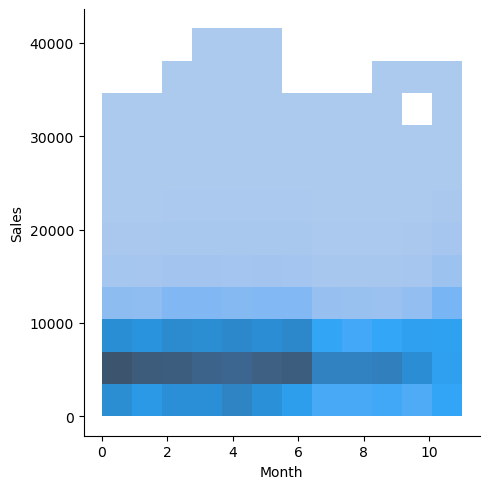

In [10]:
sns.displot(y=df.Sales,x=df.Month,bins=12)

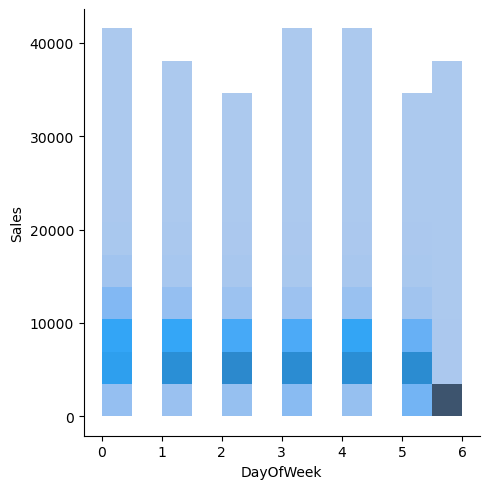

In [11]:
sns.displot(y=df.Sales,x=df.DayOfWeek,bins=12)

In [12]:
corr_df = df.corr().loc['Sales'].apply(lambda x: np.abs(x))
# corr_df = corr_df[corr_df > 0.5
# corr_df
corr_df[corr_df>0.1]

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_21026/1491233022.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr().loc['Sales'].apply(lambda x: np.abs(x))


DayOfWeek               0.462125
Sales                   1.000000
Customers               0.894711
Open                    0.678472
Promo                   0.452345
StateHoliday            0.229029
StateHoliday_bool       0.254216
AfterPromo              0.213378
BeforePromo             0.290366
StateHoliday_bool_bw    0.109792
Promo_fw                0.138871
Name: Sales, dtype: float64

In [13]:
DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']]

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_21026/1216867301.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']]


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
uniques,1115,7,942,21734,4086,2,2,4,2,3,...,136,147,21,17,8,3,6,8,3,6
types,numeric,numeric,date,numeric,numeric,bool,bool,numeric,bool,numeric,...,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric
missing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']].T.groupby('types').max()

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_21026/190154049.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']].T.groupby('types').max()


,uniques,missing
types,,
bool,2,0
categorical,135,0
constant,1,0
date,942,0
numeric,21734,0
unique,0,1017209


# Data Model

In [15]:
cat_vars = ['Store','DayOfWeek','Year','Month','Day','StateHoliday','CompetitionMonthsOpen',
    'Promo2Weeks','StoreType','Assortment','PromoInterval',
    'CompetitionOpenSinceYear','Promo2SinceYear','State',
    'Week','Events','Promo_fw','Promo_bw','SchoolHoliday_fw','SchoolHoliday_bw']

In [16]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']

In [17]:
# Check all columns on df are consistent with name of variables
# display(set(contin_vars+cat_vars))
# display(set(df.columns))
set(df.columns)-set(contin_vars+cat_vars)

{'AfterPromo',
 'AfterSchoolHoliday',
 'BeforePromo',
 'BeforeSchoolHoliday',
 'CompetitionDaysOpen',
 'CompetitionOpenSince',
 'CompetitionOpenSinceMonth',
 'Customers',
 'Date',
 'Date_DE',
 'Date_y',
 'Day_DE',
 'Day_y',
 'Dew_PointC',
 'Max_Gust_SpeedKm_h',
 'Max_Sea_Level_PressurehPa',
 'Max_VisibilityKm',
 'MeanDew_PointC',
 'Mean_Sea_Level_PressurehPa',
 'Mean_VisibilityKm',
 'Min_DewpointC',
 'Min_Sea_Level_PressurehPa',
 'Min_VisibilitykM',
 'Month_DE',
 'Month_y',
 'Open',
 'Promo2',
 'Promo2Days',
 'Promo2Since',
 'Promo2SinceWeek',
 'Sales',
 'StateHoliday_bool_bw',
 'StateHoliday_bool_fw',
 'StateName',
 'State_DE',
 'Week_y',
 'WindDirDegrees',
 'Year_y',
 'file',
 'file_DE',
 'file_y',
 'week',
 'week_DE'}

In [18]:
from tensorflow.keras import backend as K
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/(y_true))))

In [19]:
def calculate_RMSE(X, y, model, log_output=True):
    y_preds = np.exp(model.predict(X, verbose=1)*max_log_y)
    return np.sqrt((((y - y_preds)/y)**2).sum()/len(y_preds))

### Split Data for Train and Validation

In [20]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [21]:
split_contins = False
def split_data():
    if split_contins:
        map_train = split_cols(cats_trn) + split_cols(contins_trn)
        map_valid = split_cols(cats_val) + split_cols(contins_val)
    else:
        map_train = cats_trn+contins_trn
        map_valid = cats_val+contins_val
    return map_train, map_valid

In [60]:
n=len(df.Sales)

train_ratio=0.9
train_size = int(n*train_ratio)
# contins_trn, contins_val = df[contin_vars].loc[:train_size-1], df[contin_vars].loc[train_size:]
# cats_trn, cats_val       = df[cat_var_dict.keys()].loc[:train_size-1], df[cat_var_dict.keys()].loc[train_size:]

X_train,X_valid                  = df[cat_vars+contin_vars].loc[:train_size-1], df[cat_vars+contin_vars].loc[train_size:]

max_y_log                = (np.log(df.Sales)).values.max()
y_trn, y_val             = np.log(df.Sales.loc[:train_size-1])/max_y_log, np.log(df.Sales.loc[train_size:])/max_y_log

print("X_train[",type(X_train),"]: ",X_train.shape,"      y_trn[",type(y_trn),"]: ",y_trn.shape)
print("X_valid[",type(X_train),"]: ",X_valid.shape,"      y_val[",type(y_val),"]: ",y_val.shape)

X_train[ <class 'pandas.core.frame.DataFrame'> ]:  (915488, 38)       y_trn[ <class 'pandas.core.series.Series'> ]:  (915488,)
X_valid[ <class 'pandas.core.frame.DataFrame'> ]:  (101721, 38)       y_val[ <class 'pandas.core.series.Series'> ]:  (101721,)


/Users/facundosolano/opt/anaconda3/envs/itba/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


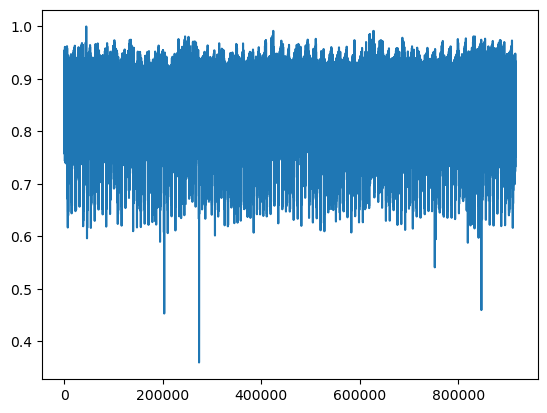

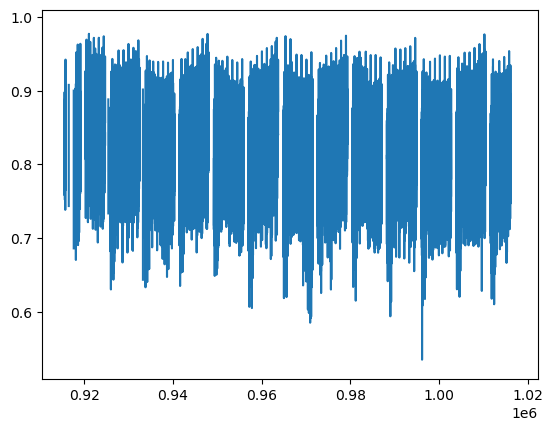

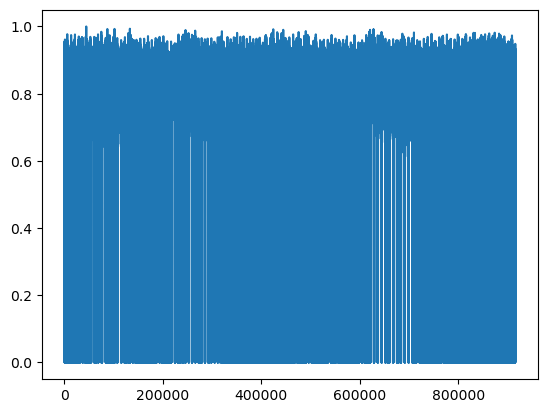

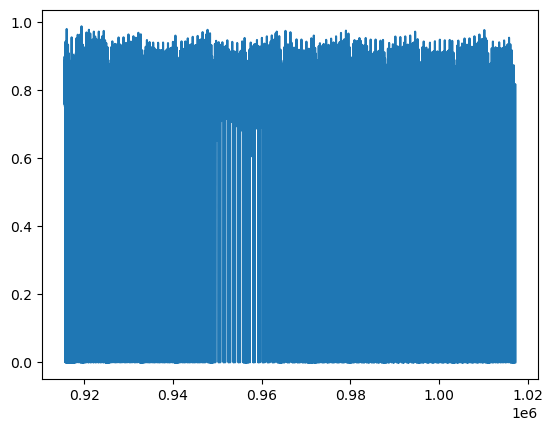

In [61]:
plt.plot(y_trn)
plt.figure()
plt.plot(y_val)
y_trn.loc[lambda x: x < 0.0] = 0
y_val.loc[lambda x: x < 0.0] = 0
plt.figure()
plt.plot(y_trn)
plt.figure()
plt.plot(y_val)

In [37]:
# X_train,X_valid

### Search of Hyperparameters with HyperOpt

In [54]:
def objective(params):
    params = {
        # 'max_depth': int(params['max_depth']),
        # 'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'learning_rate': '{:.4f}'.format(params['learning_rate'])
        # 'n_estimators': int(params['n_estimators'])
    }
    
    clf = LGBMRegressor(
        n_estimators=4000,
        min_child_samples= 5,# max_depth= -1,
        device_type='cpu',
        n_jobs=3,
        **params
    )
    
    score = -cross_val_score(clf, X_train, y_trn).mean()
    return score

In [56]:
space = {
    # 'max_depth': hp.uniform('max_depth', 1, 63),
    # # 'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', -4, -2),
    # 'n_estimators': hp.uniform('n_estimators',100,4000)
}

best = fmin(fn=objective,
            space=space,
            verbose=2,
            algo=tpe.suggest,
            max_evals=10)

In [ ]:
best

### Search Hyperparameters with GridSearch

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
parameters = {
        'learning_rate':[0.001, 0.05, 0.1, 0.5],
        'max_depth':[1, 7, 31, 63],
        'min_child_samples': [5,10,20,100],
        'n_estimators': [100,1000,4000]
    }
# grid_search_res_1 = {'learning_rate': 0.05, 'min_child_samples': 5, 'max_depth': -1}
grid_search_res_2 = {'n_estimators':4000,'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 20}

In [64]:
n_estimators = 1000

model = LGBMRegressor(**grid_search_res_2)

In [65]:
clf = GridSearchCV(model, parameters, n_jobs=-1, verbose=1, cv=3)

### Create Model

In [66]:
n_estimators  = 1000

def get_model(params):
    model = LGBMRegressor(
        n_estimators=n_estimators,
        min_child_samples= 5,
        n_jobs=-1,
        **params
    )
    return model

In [67]:
X_train.shape

(915488, 38)

In [68]:
gridsearch_en = True

def train(model, X_train, X_valid):    
    fit_params={ "eval_metric" : 'l2', 
            'verbose': 100,
            #'feature_name': 'auto', # that's actually the default
            # 'categorical_feature': cat_vars
            }

    fit_params["eval_set"] = [(X_valid, y_val)]
    fit_params["early_stopping_rounds"] = 100
    
    if gridsearch_en:
        return model.fit(X_train, y_trn, **fit_params)
    else:
        return model.fit(X_train, y_trn, **fit_params)

### Train Model and Split Data

In [69]:
if gridsearch_en:
    train(clf, X_train, X_valid)
else:
    model = get_model(best)
    train(model, X_train, X_valid)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0859245
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0859245
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0859091
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0859091


/Users/facundosolano/opt/anaconda3/envs/itba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0859091
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0859091
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0859245
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0859245
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0859179
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0859179
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0859091
[200]	valid_0's l2: 0.0751394
[300]	valid_0's l2: 0.0663333
[400]	valid_0's l2: 0.0591337
[500]	valid_0's l2: 0.0532484
[600]	valid_0's l2: 0.0484381
[700]	valid_0's l2: 0.0445072
[800]	valid_0's l2: 0.0411533
[900]	valid_0's l2: 0.0380433
[1000]	valid_0's l2: 0.0352201
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0352201
Training until validation scores don't improve f

KeyboardInterrupt: 

# Submit Competition

In [ ]:
X_test = df_test[cat_vars+contin_vars].loc[:train_size-1]

In [ ]:
# y_pred = np.exp(clf.predict(X_valid)*max_y_log)[:,0]
# y_pred_test = np.exp(clf.predict(X_test)*max_y_log)[:,0]
y_pred = np.exp(clf.predict(X_valid)*max_y_log)
y_pred_test = np.exp(clf.predict(X_test)*max_y_log)
display(y_pred_test.shape)

In [75]:
sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_lightGBM.csv', index=False)